In [1]:
# Parameters
classes = 3
lossfn = "relu"
BATCH = False
EPOCHS = 450
DROPRATE = 0.3
optim = "adam"
EXP_ID = "Train1"


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import os.path as osp
from datetime import datetime
import ipykernel

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
style.use('ggplot')
import keras.backend as K
import keras as keras
from keras.models import Sequential,Model
# from keras.metrics import mae, categorical_accuracy

from keras.layers import MaxPooling1D, Dense, Dropout, Flatten, Input, Conv1D, LeakyReLU, BatchNormalization, Softmax


Using TensorFlow backend.


In [4]:
# # curr_path = os.getcwd()
# # curr_path
# # lossfn = LeakyReLU(alpha=0.02)
# optim = 'adam'
# lossfn = 'relu'
# BATCH = False
# EPOCHS = 500
# DROPRATE = 0.4
# classes = 4
# EXP_ID = 'Train1'

In [5]:
fold_dict = {}
if classes == 4:
    fold_dict = {"O":[0, 0,0,1],"F":[0, 0,1,0], 'S':[0, 1,0,0], "N":[1, 0,0,0]}
elif classes == 3:
    fold_dict = {"O":[0,0,1],"F":[0,1,0], 'S':[1,0,0]}
# out_len = len(fold_dict.keys())

In [6]:
TEST_ID = "cls:{}_loss:{}_bnm:{}_drop:{}_epo:{}_opt:{}".format(classes, lossfn, BATCH, DROPRATE, EPOCHS, optim)
PLT_TITLE = "{} classes, {} actvn, {} BN, {} dropout, {} opt".format(classes, lossfn, BATCH, DROPRATE, optim)
TEST_ID

'cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam'

In [7]:
curr_time = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
data_dir = 'data'
chk_dir = 'checkpoints'
plot_dir = osp.join('plots', EXP_ID)
logdir = "logs/scalars/" + EXP_ID
logdir = osp.join(logdir, curr_time)
tb_callback = keras.callbacks.TensorBoard(log_dir=logdir)
for dirn in [data_dir, chk_dir, plot_dir]:
    os.makedirs(dirn, exist_ok=True)

In [8]:
def extract(fold,label):
    fold_arr = []
    labels_arr = []
    files = []
    for f in os.listdir(fold):
        files.append(osp.join(fold, f))


    for f in files:

        lines = []
        with open(f, 'r') as fw:
            for i, line in enumerate(fw):
                lines.append(int(line.split()[0]))
        lines_arr = np.array(lines)
        lines_arr=(lines_arr-np.mean(lines_arr))/np.var(lines_arr)
        fold_arr.append(lines_arr)
        labels_arr.append(label)
    return fold_arr,labels_arr

In [9]:
fin_list = []
train_X = []
train_Y = []
for key,val in fold_dict.items():
    x,y = extract(osp.join(data_dir,key),val)
    train_X.extend(x)
    train_Y.extend(y)

In [10]:
len(train_X),len(train_Y)

(300, 300)

In [11]:
in_lay = Input((4097,1))


l1 = Conv1D(4, kernel_size = 6, strides=1, padding = 'same',activation = lossfn)(in_lay)
ml1 = MaxPooling1D(pool_size=2, strides=2)(l1)
if BATCH: ml1 = BatchNormalization()(ml1)

l1 = Conv1D(4, kernel_size = 5, strides=1, padding = 'same',activation = lossfn)(ml1)
ml1 = MaxPooling1D(pool_size=2, strides=2)(l1)
if BATCH: ml1 = BatchNormalization()(ml1)

l1 = Conv1D(10, kernel_size = 4, strides=1, padding = 'same',activation = lossfn)(ml1)
ml1 = MaxPooling1D(pool_size=2, strides=2)(l1)
if BATCH: ml1 = BatchNormalization()(ml1)

l1 = Conv1D(10, kernel_size = 4, strides=1, padding = 'same',activation = lossfn)(ml1)
ml1 = MaxPooling1D(pool_size=2, strides=2)(l1)
if BATCH: ml1 = BatchNormalization()(ml1)

l1 = Conv1D(15, kernel_size = 4, strides=1, padding = 'same',activation = lossfn)(ml1)
ml1 = MaxPooling1D(pool_size=2, strides=2)(l1)
if BATCH: ml1 = BatchNormalization()(ml1)

l1 = Conv1D(15, kernel_size = 4, strides=1, padding = 'same',activation = lossfn)(ml1)
ml1 = MaxPooling1D(pool_size=2, strides=2)(l1)
if BATCH: ml1 = BatchNormalization()(ml1)
    
l1 = Conv1D(20, kernel_size = 3, strides=1, padding = 'same',activation = lossfn)(ml1)
ml1 = MaxPooling1D(pool_size=2, strides=2)(l1)
if BATCH: ml1 = BatchNormalization()(ml1)

flat = Flatten()(ml1)
flat = Dropout(DROPRATE)(flat)

flat = Dense(50)(flat)
flat = Dropout(DROPRATE)(flat)

flat = Dense(20)(flat)
flat = Dropout(DROPRATE)(flat)

flat = Dense(classes)(flat)

flat = Softmax()(flat)

model=Model(inputs = [in_lay], outputs = [flat])
model.compile(optimizer = optim, 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy'])
#                                                                              , mae, categorical_accuracy])
# model.summary()

In [12]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path = osp.join(chk_dir, 
                       "{}_{}_weights.best.hdf5".format('epilepsy', 
                                                        TEST_ID))

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', 
                                   factor=0.998, 
                                   patience=10, 
                                   verbose=1, 
                                   mode='auto', 
                                   min_delta=0.0001, 
                                   cooldown=5, 
                                   min_lr=0.0000001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=150)
callbacks_list = [checkpoint, early, reduceLROnPlat, tb_callback]

In [13]:
DATA = np.array(train_X)
LABEL = np.array(train_Y)

DATA = DATA.reshape((DATA.shape[0], DATA.shape[1], 1))
# LABEL = LABEL.reshape((LABEL.shape[0], LABEL.shape[1], 1))

# DATA.shape, LABEL.shape

In [14]:
hist=model.fit(DATA,LABEL, 
               batch_size=900,
               validation_split=0.1,
               callbacks = callbacks_list,
               epochs=EPOCHS, 
               shuffle=True,
               verbose=0
              )


Epoch 00001: val_loss improved from inf to 1.11204, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5

Epoch 00002: val_loss did not improve from 1.11204

Epoch 00003: val_loss did not improve from 1.11204



Epoch 00004: val_loss did not improve from 1.11204

Epoch 00005: val_loss did not improve from 1.11204

Epoch 00006: val_loss did not improve from 1.11204

Epoch 00007: val_loss did not improve from 1.11204



Epoch 00008: val_loss did not improve from 1.11204

Epoch 00009: val_loss did not improve from 1.11204

Epoch 00010: val_loss did not improve from 1.11204

Epoch 00011: val_loss did not improve from 1.11204

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0009980000474024565.



Epoch 00012: val_loss did not improve from 1.11204

Epoch 00013: val_loss did not improve from 1.11204

Epoch 00014: val_loss did not improve from 1.11204

Epoch 00015: val_loss did not improve from 1.11204



Epoch 00016: val_loss did not improve from 1.11204

Epoch 00017: val_loss did not improve from 1.11204

Epoch 00018: val_loss did not improve from 1.11204

Epoch 00019: val_loss did not improve from 1.11204



Epoch 00020: val_loss did not improve from 1.11204

Epoch 00021: val_loss did not improve from 1.11204

Epoch 00022: val_loss did not improve from 1.11204

Epoch 00023: val_loss did not improve from 1.11204



Epoch 00024: val_loss did not improve from 1.11204

Epoch 00025: val_loss improved from 1.11204 to 1.05862, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5

Epoch 00026: val_loss improved from 1.05862 to 1.02692, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5

Epoch 00027: val_loss improved from 1.02692 to 1.01584, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5



Epoch 00028: val_loss improved from 1.01584 to 0.96022, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5

Epoch 00029: val_loss improved from 0.96022 to 0.88223, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5

Epoch 00030: val_loss improved from 0.88223 to 0.83502, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5



Epoch 00031: val_loss improved from 0.83502 to 0.80753, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5

Epoch 00032: val_loss improved from 0.80753 to 0.74949, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5

Epoch 00033: val_loss improved from 0.74949 to 0.64481, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5



Epoch 00034: val_loss improved from 0.64481 to 0.59619, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5

Epoch 00035: val_loss did not improve from 0.59619

Epoch 00036: val_loss improved from 0.59619 to 0.54198, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5

Epoch 00037: val_loss improved from 0.54198 to 0.43689, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5



Epoch 00038: val_loss did not improve from 0.43689

Epoch 00039: val_loss did not improve from 0.43689

Epoch 00040: val_loss improved from 0.43689 to 0.41160, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5

Epoch 00041: val_loss improved from 0.41160 to 0.30732, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5



Epoch 00042: val_loss did not improve from 0.30732

Epoch 00043: val_loss did not improve from 0.30732

Epoch 00044: val_loss did not improve from 0.30732

Epoch 00045: val_loss did not improve from 0.30732



Epoch 00046: val_loss did not improve from 0.30732

Epoch 00047: val_loss did not improve from 0.30732

Epoch 00048: val_loss did not improve from 0.30732

Epoch 00049: val_loss did not improve from 0.30732



Epoch 00050: val_loss did not improve from 0.30732

Epoch 00051: val_loss did not improve from 0.30732

Epoch 00051: ReduceLROnPlateau reducing learning rate to 0.0009960040322039277.

Epoch 00052: val_loss did not improve from 0.30732

Epoch 00053: val_loss did not improve from 0.30732



Epoch 00054: val_loss did not improve from 0.30732

Epoch 00055: val_loss did not improve from 0.30732

Epoch 00056: val_loss did not improve from 0.30732

Epoch 00057: val_loss did not improve from 0.30732



Epoch 00058: val_loss did not improve from 0.30732

Epoch 00059: val_loss did not improve from 0.30732

Epoch 00060: val_loss did not improve from 0.30732

Epoch 00061: val_loss did not improve from 0.30732



Epoch 00062: val_loss did not improve from 0.30732

Epoch 00063: val_loss did not improve from 0.30732

Epoch 00064: val_loss did not improve from 0.30732

Epoch 00065: val_loss did not improve from 0.30732

Epoch 00065: ReduceLROnPlateau reducing learning rate to 0.000994011967210099.



Epoch 00066: val_loss did not improve from 0.30732

Epoch 00067: val_loss did not improve from 0.30732

Epoch 00068: val_loss did not improve from 0.30732

Epoch 00069: val_loss did not improve from 0.30732



Epoch 00070: val_loss did not improve from 0.30732

Epoch 00071: val_loss did not improve from 0.30732

Epoch 00072: val_loss did not improve from 0.30732

Epoch 00073: val_loss did not improve from 0.30732



Epoch 00074: val_loss did not improve from 0.30732

Epoch 00075: val_loss did not improve from 0.30732

Epoch 00076: val_loss did not improve from 0.30732

Epoch 00077: val_loss did not improve from 0.30732



Epoch 00078: val_loss did not improve from 0.30732

Epoch 00079: val_loss did not improve from 0.30732

Epoch 00079: ReduceLROnPlateau reducing learning rate to 0.000992023968603462.

Epoch 00080: val_loss did not improve from 0.30732

Epoch 00081: val_loss did not improve from 0.30732



Epoch 00082: val_loss did not improve from 0.30732

Epoch 00083: val_loss did not improve from 0.30732

Epoch 00084: val_loss did not improve from 0.30732

Epoch 00085: val_loss did not improve from 0.30732



Epoch 00086: val_loss did not improve from 0.30732

Epoch 00087: val_loss did not improve from 0.30732

Epoch 00088: val_loss did not improve from 0.30732

Epoch 00089: val_loss did not improve from 0.30732



Epoch 00090: val_loss did not improve from 0.30732

Epoch 00091: val_loss did not improve from 0.30732

Epoch 00092: val_loss did not improve from 0.30732

Epoch 00093: val_loss did not improve from 0.30732

Epoch 00093: ReduceLROnPlateau reducing learning rate to 0.000990039920201525.



Epoch 00094: val_loss improved from 0.30732 to 0.28720, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5

Epoch 00095: val_loss did not improve from 0.28720

Epoch 00096: val_loss did not improve from 0.28720

Epoch 00097: val_loss did not improve from 0.28720



Epoch 00098: val_loss did not improve from 0.28720

Epoch 00099: val_loss did not improve from 0.28720

Epoch 00100: val_loss did not improve from 0.28720

Epoch 00101: val_loss did not improve from 0.28720



Epoch 00102: val_loss did not improve from 0.28720

Epoch 00103: val_loss did not improve from 0.28720

Epoch 00104: val_loss did not improve from 0.28720

Epoch 00105: val_loss did not improve from 0.28720



Epoch 00106: val_loss improved from 0.28720 to 0.28449, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5

Epoch 00107: val_loss did not improve from 0.28449

Epoch 00108: val_loss did not improve from 0.28449

Epoch 00109: val_loss did not improve from 0.28449



Epoch 00110: val_loss did not improve from 0.28449

Epoch 00111: val_loss did not improve from 0.28449

Epoch 00112: val_loss improved from 0.28449 to 0.24230, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5

Epoch 00113: val_loss improved from 0.24230 to 0.21088, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5



Epoch 00114: val_loss did not improve from 0.21088

Epoch 00115: val_loss did not improve from 0.21088

Epoch 00116: val_loss did not improve from 0.21088

Epoch 00117: val_loss improved from 0.21088 to 0.18846, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5



Epoch 00118: val_loss did not improve from 0.18846

Epoch 00119: val_loss did not improve from 0.18846

Epoch 00120: val_loss did not improve from 0.18846

Epoch 00121: val_loss improved from 0.18846 to 0.18329, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5



Epoch 00122: val_loss did not improve from 0.18329

Epoch 00123: val_loss did not improve from 0.18329

Epoch 00124: val_loss did not improve from 0.18329

Epoch 00125: val_loss improved from 0.18329 to 0.17258, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5



Epoch 00126: val_loss did not improve from 0.17258

Epoch 00127: val_loss did not improve from 0.17258

Epoch 00128: val_loss did not improve from 0.17258

Epoch 00129: val_loss improved from 0.17258 to 0.16295, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5



Epoch 00130: val_loss did not improve from 0.16295

Epoch 00131: val_loss did not improve from 0.16295

Epoch 00132: val_loss improved from 0.16295 to 0.16262, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5

Epoch 00133: val_loss improved from 0.16262 to 0.13535, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5



Epoch 00134: val_loss did not improve from 0.13535

Epoch 00135: val_loss did not improve from 0.13535

Epoch 00136: val_loss did not improve from 0.13535

Epoch 00137: val_loss did not improve from 0.13535



Epoch 00138: val_loss did not improve from 0.13535

Epoch 00139: val_loss did not improve from 0.13535

Epoch 00140: val_loss did not improve from 0.13535

Epoch 00141: val_loss did not improve from 0.13535



Epoch 00142: val_loss did not improve from 0.13535

Epoch 00143: val_loss did not improve from 0.13535

Epoch 00143: ReduceLROnPlateau reducing learning rate to 0.0009880598220042885.

Epoch 00144: val_loss did not improve from 0.13535

Epoch 00145: val_loss did not improve from 0.13535



Epoch 00146: val_loss improved from 0.13535 to 0.11208, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5

Epoch 00147: val_loss did not improve from 0.11208

Epoch 00148: val_loss did not improve from 0.11208

Epoch 00149: val_loss did not improve from 0.11208



Epoch 00150: val_loss did not improve from 0.11208

Epoch 00151: val_loss did not improve from 0.11208

Epoch 00152: val_loss did not improve from 0.11208

Epoch 00153: val_loss did not improve from 0.11208



Epoch 00154: val_loss improved from 0.11208 to 0.10628, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5

Epoch 00155: val_loss improved from 0.10628 to 0.10220, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5

Epoch 00156: val_loss did not improve from 0.10220

Epoch 00157: val_loss did not improve from 0.10220



Epoch 00158: val_loss did not improve from 0.10220

Epoch 00159: val_loss did not improve from 0.10220

Epoch 00160: val_loss improved from 0.10220 to 0.09795, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5

Epoch 00161: val_loss improved from 0.09795 to 0.08216, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5



Epoch 00162: val_loss did not improve from 0.08216

Epoch 00163: val_loss did not improve from 0.08216

Epoch 00164: val_loss did not improve from 0.08216

Epoch 00165: val_loss did not improve from 0.08216



Epoch 00166: val_loss did not improve from 0.08216

Epoch 00167: val_loss did not improve from 0.08216

Epoch 00168: val_loss improved from 0.08216 to 0.07514, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5

Epoch 00169: val_loss improved from 0.07514 to 0.07509, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5



Epoch 00170: val_loss did not improve from 0.07509

Epoch 00171: val_loss did not improve from 0.07509

Epoch 00172: val_loss did not improve from 0.07509

Epoch 00173: val_loss did not improve from 0.07509



Epoch 00174: val_loss did not improve from 0.07509

Epoch 00175: val_loss did not improve from 0.07509

Epoch 00176: val_loss did not improve from 0.07509

Epoch 00177: val_loss improved from 0.07509 to 0.06879, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5



Epoch 00178: val_loss did not improve from 0.06879

Epoch 00179: val_loss did not improve from 0.06879

Epoch 00180: val_loss did not improve from 0.06879

Epoch 00181: val_loss did not improve from 0.06879



Epoch 00182: val_loss improved from 0.06879 to 0.06459, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5

Epoch 00183: val_loss did not improve from 0.06459

Epoch 00184: val_loss did not improve from 0.06459

Epoch 00185: val_loss improved from 0.06459 to 0.06428, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5



Epoch 00186: val_loss improved from 0.06428 to 0.06205, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5

Epoch 00187: val_loss did not improve from 0.06205

Epoch 00188: val_loss did not improve from 0.06205

Epoch 00189: val_loss did not improve from 0.06205



Epoch 00190: val_loss improved from 0.06205 to 0.05818, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5

Epoch 00191: val_loss improved from 0.05818 to 0.04991, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5

Epoch 00192: val_loss did not improve from 0.04991

Epoch 00193: val_loss did not improve from 0.04991



Epoch 00194: val_loss did not improve from 0.04991

Epoch 00195: val_loss did not improve from 0.04991

Epoch 00196: val_loss did not improve from 0.04991



Epoch 00197: val_loss did not improve from 0.04991

Epoch 00198: val_loss did not improve from 0.04991

Epoch 00199: val_loss improved from 0.04991 to 0.04355, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5

Epoch 00200: val_loss did not improve from 0.04355



Epoch 00201: val_loss did not improve from 0.04355

Epoch 00202: val_loss did not improve from 0.04355

Epoch 00203: val_loss improved from 0.04355 to 0.03651, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5

Epoch 00204: val_loss did not improve from 0.03651



Epoch 00205: val_loss did not improve from 0.03651

Epoch 00206: val_loss did not improve from 0.03651

Epoch 00207: val_loss did not improve from 0.03651

Epoch 00208: val_loss did not improve from 0.03651



Epoch 00209: val_loss did not improve from 0.03651

Epoch 00210: val_loss did not improve from 0.03651

Epoch 00211: val_loss did not improve from 0.03651

Epoch 00212: val_loss improved from 0.03651 to 0.03503, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5



Epoch 00213: val_loss improved from 0.03503 to 0.03331, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5

Epoch 00214: val_loss did not improve from 0.03331

Epoch 00215: val_loss did not improve from 0.03331

Epoch 00216: val_loss did not improve from 0.03331



Epoch 00217: val_loss improved from 0.03331 to 0.01883, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5

Epoch 00218: val_loss did not improve from 0.01883

Epoch 00219: val_loss did not improve from 0.01883

Epoch 00220: val_loss improved from 0.01883 to 0.01092, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5



Epoch 00221: val_loss did not improve from 0.01092

Epoch 00222: val_loss did not improve from 0.01092

Epoch 00223: val_loss did not improve from 0.01092

Epoch 00224: val_loss did not improve from 0.01092



Epoch 00225: val_loss did not improve from 0.01092

Epoch 00226: val_loss did not improve from 0.01092

Epoch 00227: val_loss did not improve from 0.01092

Epoch 00228: val_loss did not improve from 0.01092



Epoch 00229: val_loss did not improve from 0.01092

Epoch 00230: val_loss did not improve from 0.01092

Epoch 00230: ReduceLROnPlateau reducing learning rate to 0.000986083674011752.

Epoch 00231: val_loss did not improve from 0.01092

Epoch 00232: val_loss did not improve from 0.01092



Epoch 00233: val_loss did not improve from 0.01092

Epoch 00234: val_loss did not improve from 0.01092

Epoch 00235: val_loss did not improve from 0.01092

Epoch 00236: val_loss did not improve from 0.01092



Epoch 00237: val_loss did not improve from 0.01092

Epoch 00238: val_loss did not improve from 0.01092

Epoch 00239: val_loss did not improve from 0.01092

Epoch 00240: val_loss did not improve from 0.01092



Epoch 00241: val_loss did not improve from 0.01092

Epoch 00242: val_loss did not improve from 0.01092

Epoch 00243: val_loss did not improve from 0.01092

Epoch 00244: val_loss did not improve from 0.01092

Epoch 00244: ReduceLROnPlateau reducing learning rate to 0.0009841114762239157.



Epoch 00245: val_loss did not improve from 0.01092

Epoch 00246: val_loss did not improve from 0.01092

Epoch 00247: val_loss did not improve from 0.01092

Epoch 00248: val_loss did not improve from 0.01092



Epoch 00249: val_loss did not improve from 0.01092

Epoch 00250: val_loss did not improve from 0.01092

Epoch 00251: val_loss did not improve from 0.01092

Epoch 00252: val_loss did not improve from 0.01092



Epoch 00253: val_loss did not improve from 0.01092

Epoch 00254: val_loss did not improve from 0.01092

Epoch 00255: val_loss did not improve from 0.01092

Epoch 00256: val_loss did not improve from 0.01092



Epoch 00257: val_loss did not improve from 0.01092

Epoch 00258: val_loss did not improve from 0.01092

Epoch 00258: ReduceLROnPlateau reducing learning rate to 0.00098214322864078.

Epoch 00259: val_loss did not improve from 0.01092

Epoch 00260: val_loss did not improve from 0.01092



Epoch 00261: val_loss did not improve from 0.01092

Epoch 00262: val_loss did not improve from 0.01092

Epoch 00263: val_loss did not improve from 0.01092

Epoch 00264: val_loss did not improve from 0.01092



Epoch 00265: val_loss did not improve from 0.01092

Epoch 00266: val_loss did not improve from 0.01092

Epoch 00267: val_loss did not improve from 0.01092

Epoch 00268: val_loss did not improve from 0.01092



Epoch 00269: val_loss did not improve from 0.01092

Epoch 00270: val_loss did not improve from 0.01092

Epoch 00271: val_loss did not improve from 0.01092

Epoch 00272: val_loss did not improve from 0.01092

Epoch 00272: ReduceLROnPlateau reducing learning rate to 0.000980178931262344.



Epoch 00273: val_loss did not improve from 0.01092

Epoch 00274: val_loss did not improve from 0.01092

Epoch 00275: val_loss did not improve from 0.01092

Epoch 00276: val_loss did not improve from 0.01092



Epoch 00277: val_loss did not improve from 0.01092

Epoch 00278: val_loss did not improve from 0.01092

Epoch 00279: val_loss did not improve from 0.01092

Epoch 00280: val_loss did not improve from 0.01092



Epoch 00281: val_loss did not improve from 0.01092

Epoch 00282: val_loss did not improve from 0.01092

Epoch 00283: val_loss did not improve from 0.01092

Epoch 00284: val_loss improved from 0.01092 to 0.00607, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5



Epoch 00285: val_loss did not improve from 0.00607

Epoch 00286: val_loss did not improve from 0.00607

Epoch 00287: val_loss improved from 0.00607 to 0.00530, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5

Epoch 00288: val_loss improved from 0.00530 to 0.00456, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5



Epoch 00289: val_loss did not improve from 0.00456

Epoch 00290: val_loss did not improve from 0.00456

Epoch 00291: val_loss did not improve from 0.00456

Epoch 00292: val_loss improved from 0.00456 to 0.00422, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5



Epoch 00293: val_loss improved from 0.00422 to 0.00342, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5

Epoch 00294: val_loss did not improve from 0.00342

Epoch 00295: val_loss did not improve from 0.00342

Epoch 00296: val_loss did not improve from 0.00342



Epoch 00297: val_loss improved from 0.00342 to 0.00319, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5

Epoch 00298: val_loss did not improve from 0.00319

Epoch 00299: val_loss did not improve from 0.00319

Epoch 00300: val_loss did not improve from 0.00319



Epoch 00301: val_loss did not improve from 0.00319

Epoch 00302: val_loss did not improve from 0.00319

Epoch 00303: val_loss did not improve from 0.00319

Epoch 00304: val_loss did not improve from 0.00319



Epoch 00305: val_loss did not improve from 0.00319

Epoch 00306: val_loss improved from 0.00319 to 0.00305, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5

Epoch 00307: val_loss did not improve from 0.00305

Epoch 00308: val_loss did not improve from 0.00305



Epoch 00309: val_loss did not improve from 0.00305

Epoch 00310: val_loss did not improve from 0.00305

Epoch 00311: val_loss did not improve from 0.00305

Epoch 00312: val_loss did not improve from 0.00305



Epoch 00313: val_loss did not improve from 0.00305

Epoch 00314: val_loss did not improve from 0.00305

Epoch 00315: val_loss did not improve from 0.00305

Epoch 00316: val_loss did not improve from 0.00305

Epoch 00316: ReduceLROnPlateau reducing learning rate to 0.0009782185840886085.



Epoch 00317: val_loss did not improve from 0.00305

Epoch 00318: val_loss did not improve from 0.00305

Epoch 00319: val_loss did not improve from 0.00305

Epoch 00320: val_loss did not improve from 0.00305



Epoch 00321: val_loss did not improve from 0.00305

Epoch 00322: val_loss did not improve from 0.00305

Epoch 00323: val_loss did not improve from 0.00305

Epoch 00324: val_loss did not improve from 0.00305



Epoch 00325: val_loss did not improve from 0.00305

Epoch 00326: val_loss did not improve from 0.00305

Epoch 00327: val_loss did not improve from 0.00305

Epoch 00328: val_loss did not improve from 0.00305



Epoch 00329: val_loss did not improve from 0.00305

Epoch 00330: val_loss did not improve from 0.00305

Epoch 00330: ReduceLROnPlateau reducing learning rate to 0.0009762621871195734.

Epoch 00331: val_loss did not improve from 0.00305

Epoch 00332: val_loss did not improve from 0.00305



Epoch 00333: val_loss did not improve from 0.00305

Epoch 00334: val_loss did not improve from 0.00305

Epoch 00335: val_loss did not improve from 0.00305

Epoch 00336: val_loss did not improve from 0.00305



Epoch 00337: val_loss did not improve from 0.00305

Epoch 00338: val_loss did not improve from 0.00305

Epoch 00339: val_loss did not improve from 0.00305

Epoch 00340: val_loss did not improve from 0.00305



Epoch 00341: val_loss did not improve from 0.00305

Epoch 00342: val_loss did not improve from 0.00305

Epoch 00343: val_loss did not improve from 0.00305

Epoch 00344: val_loss did not improve from 0.00305

Epoch 00344: ReduceLROnPlateau reducing learning rate to 0.0009743096822639927.



Epoch 00345: val_loss did not improve from 0.00305

Epoch 00346: val_loss did not improve from 0.00305

Epoch 00347: val_loss did not improve from 0.00305

Epoch 00348: val_loss did not improve from 0.00305



Epoch 00349: val_loss did not improve from 0.00305

Epoch 00350: val_loss did not improve from 0.00305

Epoch 00351: val_loss did not improve from 0.00305

Epoch 00352: val_loss did not improve from 0.00305



Epoch 00353: val_loss did not improve from 0.00305

Epoch 00354: val_loss did not improve from 0.00305

Epoch 00355: val_loss did not improve from 0.00305

Epoch 00356: val_loss did not improve from 0.00305



Epoch 00357: val_loss did not improve from 0.00305

Epoch 00358: val_loss did not improve from 0.00305

Epoch 00358: ReduceLROnPlateau reducing learning rate to 0.0009723610695218667.

Epoch 00359: val_loss did not improve from 0.00305

Epoch 00360: val_loss did not improve from 0.00305



Epoch 00361: val_loss did not improve from 0.00305

Epoch 00362: val_loss did not improve from 0.00305

Epoch 00363: val_loss did not improve from 0.00305

Epoch 00364: val_loss did not improve from 0.00305



Epoch 00365: val_loss did not improve from 0.00305

Epoch 00366: val_loss did not improve from 0.00305

Epoch 00367: val_loss improved from 0.00305 to 0.00266, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5

Epoch 00368: val_loss improved from 0.00266 to 0.00192, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5



Epoch 00369: val_loss did not improve from 0.00192

Epoch 00370: val_loss did not improve from 0.00192

Epoch 00371: val_loss improved from 0.00192 to 0.00099, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5

Epoch 00372: val_loss improved from 0.00099 to 0.00057, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5



Epoch 00373: val_loss did not improve from 0.00057

Epoch 00374: val_loss did not improve from 0.00057

Epoch 00375: val_loss did not improve from 0.00057

Epoch 00376: val_loss improved from 0.00057 to 0.00042, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5



Epoch 00377: val_loss did not improve from 0.00042

Epoch 00378: val_loss did not improve from 0.00042

Epoch 00379: val_loss did not improve from 0.00042

Epoch 00380: val_loss improved from 0.00042 to 0.00037, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5



Epoch 00381: val_loss did not improve from 0.00037

Epoch 00382: val_loss did not improve from 0.00037

Epoch 00383: val_loss did not improve from 0.00037

Epoch 00384: val_loss did not improve from 0.00037



Epoch 00385: val_loss did not improve from 0.00037

Epoch 00386: val_loss improved from 0.00037 to 0.00035, saving model to checkpoints/epilepsy_cls:3_loss:relu_bnm:False_drop:0.3_epo:450_opt:adam_weights.best.hdf5

Epoch 00386: ReduceLROnPlateau reducing learning rate to 0.0009704163488931954.

Epoch 00387: val_loss did not improve from 0.00035

Epoch 00388: val_loss did not improve from 0.00035



Epoch 00389: val_loss did not improve from 0.00035

Epoch 00390: val_loss did not improve from 0.00035

Epoch 00391: val_loss did not improve from 0.00035

Epoch 00392: val_loss did not improve from 0.00035



Epoch 00393: val_loss did not improve from 0.00035

Epoch 00394: val_loss did not improve from 0.00035

Epoch 00395: val_loss did not improve from 0.00035

Epoch 00396: val_loss did not improve from 0.00035



Epoch 00397: val_loss did not improve from 0.00035

Epoch 00398: val_loss did not improve from 0.00035

Epoch 00399: val_loss did not improve from 0.00035

Epoch 00400: val_loss did not improve from 0.00035

Epoch 00400: ReduceLROnPlateau reducing learning rate to 0.0009684755203779787.



Epoch 00401: val_loss did not improve from 0.00035

Epoch 00402: val_loss did not improve from 0.00035

Epoch 00403: val_loss did not improve from 0.00035

Epoch 00404: val_loss did not improve from 0.00035



Epoch 00405: val_loss did not improve from 0.00035

Epoch 00406: val_loss did not improve from 0.00035

Epoch 00407: val_loss did not improve from 0.00035

Epoch 00408: val_loss did not improve from 0.00035



Epoch 00409: val_loss did not improve from 0.00035

Epoch 00410: val_loss did not improve from 0.00035

Epoch 00411: val_loss did not improve from 0.00035

Epoch 00412: val_loss did not improve from 0.00035



Epoch 00413: val_loss did not improve from 0.00035

Epoch 00414: val_loss did not improve from 0.00035

Epoch 00414: ReduceLROnPlateau reducing learning rate to 0.0009665385839762166.

Epoch 00415: val_loss did not improve from 0.00035

Epoch 00416: val_loss did not improve from 0.00035



Epoch 00417: val_loss did not improve from 0.00035

Epoch 00418: val_loss did not improve from 0.00035

Epoch 00419: val_loss did not improve from 0.00035

Epoch 00420: val_loss did not improve from 0.00035



Epoch 00421: val_loss did not improve from 0.00035

Epoch 00422: val_loss did not improve from 0.00035

Epoch 00423: val_loss did not improve from 0.00035

Epoch 00424: val_loss did not improve from 0.00035



Epoch 00425: val_loss did not improve from 0.00035

Epoch 00426: val_loss did not improve from 0.00035

Epoch 00427: val_loss did not improve from 0.00035

Epoch 00428: val_loss did not improve from 0.00035

Epoch 00428: ReduceLROnPlateau reducing learning rate to 0.0009646054815966636.



Epoch 00429: val_loss did not improve from 0.00035

Epoch 00430: val_loss did not improve from 0.00035

Epoch 00431: val_loss did not improve from 0.00035

Epoch 00432: val_loss did not improve from 0.00035



Epoch 00433: val_loss did not improve from 0.00035

Epoch 00434: val_loss did not improve from 0.00035

Epoch 00435: val_loss did not improve from 0.00035

Epoch 00436: val_loss did not improve from 0.00035



Epoch 00437: val_loss did not improve from 0.00035

Epoch 00438: val_loss did not improve from 0.00035

Epoch 00439: val_loss did not improve from 0.00035

Epoch 00440: val_loss did not improve from 0.00035



Epoch 00441: val_loss did not improve from 0.00035

Epoch 00442: val_loss did not improve from 0.00035

Epoch 00442: ReduceLROnPlateau reducing learning rate to 0.0009626762713305652.

Epoch 00443: val_loss did not improve from 0.00035

Epoch 00444: val_loss did not improve from 0.00035



Epoch 00445: val_loss did not improve from 0.00035

Epoch 00446: val_loss did not improve from 0.00035

Epoch 00447: val_loss did not improve from 0.00035

Epoch 00448: val_loss did not improve from 0.00035



Epoch 00449: val_loss did not improve from 0.00035

Epoch 00450: val_loss did not improve from 0.00035


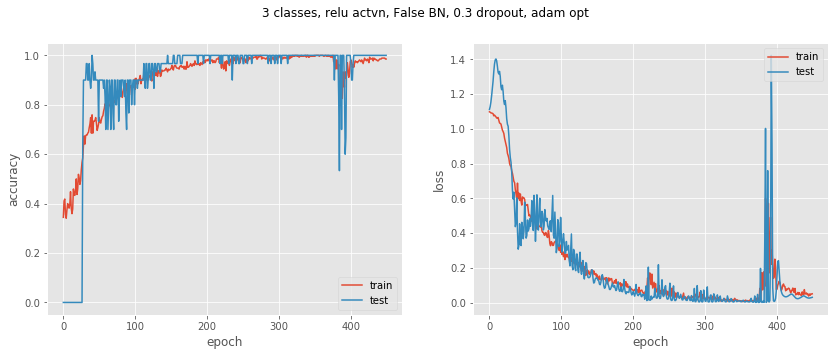

<Figure size 2880x288 with 0 Axes>

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
fig.suptitle(PLT_TITLE)
plt.figure(figsize=(40, 4))
ax1.plot(hist.history['accuracy'])
ax1.plot(hist.history['val_accuracy'])
# ax1.set_title('Accuracy\n {}'.format(PLT_TITLE))
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='lower right')

ax2.plot(hist.history['loss'])
ax2.plot(hist.history['val_loss'])
# ax2.set_title('Loss\n {}'.format(PLT_TITLE))
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper right')

fig.savefig('{}/acc_loss_{}.png'.format(plot_dir, TEST_ID))
plt.show()

In [16]:
max(hist.history['accuracy']), max(hist.history['val_accuracy']) 

(1.0, 1.0)

In [17]:
min(hist.history['loss']), min(hist.history['val_loss']) 

(0.004908028524369001, 0.0003480328887235373)